In [3]:
import matplotlib.pyplot as plt
import torch
from manage_exp import set_tensor_type

cuda = False #  torch.cuda.is_available()
tensor_type = 'double' # 'double'
set_tensor_type(tensor_type,cuda)

import filters
from manage_exp import get_x0
from lin2d_exp import get_params

exp_params = get_params()
#print(exp_params)

use gpu False
use tensor_type double


empirical mean of x0 is tensor([3.0079, 3.0029])


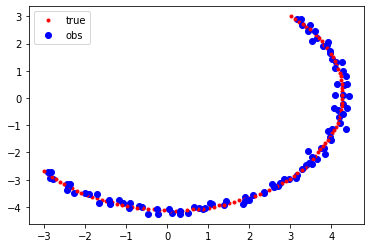

In [2]:
train_kwargs = exp_params['train_kwargs']
prop_kwargs = exp_params['prop_kwargs']
obs_kwargs = exp_params['obs_kwargs']
prop = filters.Constructor(**prop_kwargs)
obs = filters.Constructor(**obs_kwargs)

b_size = 2 # train_kwargs['b_size']
h_dim = train_kwargs['h_dim']
x_dim = train_kwargs['x_dim']
T = 100 # train_kwargs['T']

sigma = exp_params['sigma0']
x0 = get_x0(b_size, x_dim, sigma)
xt = [None]
yt = [None]
x = x0
plt.plot(x0[0,0].item(),x0[0,1].item(),'r.')
for t in range(1,T+1):
    x = prop(x)\
            .sample(sample_shape=torch.Size([1]))\
            .squeeze(0)
        #print('x norm',x.norm())

    y = obs(x)\
            .sample(sample_shape=torch.Size([1]))\
            .squeeze(0)
    xt.append(x)
    yt.append(y)
    plt.plot(y[0,0].item(),y[0,1].item(),'bo')
    plt.plot(x[0,0].item(),x[0,1].item(),'r.')

plt.legend(['true','obs'])
print('empirical mean of x0 is', torch.mean(x0,0))

In [ ]:
# IN filters
class Gaussian(Mvn):
    """
    Return a pytorch Gaussian pdf from args
    args is either a (loc, scale_tril) or a (x_dim, vec)
    """
    def __init__(self, *args):
        self.minexp = torch.Tensor([-8.0])
        self.maxexp = torch.Tensor([8.0])
        if isinstance(args[0], int):
            """args is a (x_dim, vec)
            loc is the first x_dim coeff of vec
            if the rest is one coeff c then
                scale_tril = e^c*I
            else
                scale_tril is filled diagonal by diagonal
                starting by the main one
                (which is exponentiated to ensure strict positivity)
            """
            x_dim, vec = args
            vec_dim = vec.size(-1)
            if vec_dim == x_dim + 1:
                #print('Init Mvn by x_dim+1')
                loc = vec[:, :x_dim]
                scale_tril = torch.eye(x_dim)\
                                  .unsqueeze(0)\
                                  .expand(vec.size(0), -1, -1)
                scale_tril = torch.exp(vec[:, x_dim])\
                                  .view(vec.size(0), 1, 1)*scale_tril
            else:
                #print('Init Mvn by inds')
                scale_tril = torch.zeros(vec.size(0), x_dim, x_dim)
                # TODO use vec_to_inds
                
            Mvn.__init__(self, loc=loc, scale_tril=scale_tril)
        
        else:
            """args is a loc, scale_tril
            """
            print('Init Mvn by full arg')
            Mvn.__init__(self, loc=args[0], scale_tril=args[1])

    def vec_to_inds(self, x_dim, vec_dim):
        """Computes the indices of scale_tril coeffs,
        scale_tril is filled main diagonal first

        x_dim: dimension of the random variable
        vec_dim: dimension of the vector containing
                 the coeffs of loc and scale_tril
        """
        ldiag, d, c = x_dim, 0, 0  # diag length, diag index, column index
        inds = [[], []]  # list of line and column indexes
        for i in range(vec_dim - x_dim):  # loop over the non-mean coeff
            inds[0].append(c+d)  # line index
            inds[1].append(c)  # column index
            if c == ldiag-1:  # the current diag end is reached
                ldiag += -1  # the diag length is decremented
                c = 0  # the column index is reinitialized
                d += 1  # the diag index is incremented
            else:  # otherwize, only the column index is incremented
                c += 1
        return inds